# Health Data Segmentation Project

# Prepare Dataset

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import poisson
import numpy as np
import scipy.stats as stats
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
import warnings

In [2]:
df = pd.read_csv('diseases.csv')
print("df shape:", df.shape)
df.head()

df shape: (23, 13)


Disease name       2011       2012  \
0       Number of cases diagnosed for the first time  1 554 246  1 790 278   
1                  Infectious and parasitic diseases    107 881    124 338   
2                                          Neoplasms      9 121     11 636   
3  Diseases of the endocrin system, digestion    ...     50 383     46 867   
4                                                NaN        NaN        NaN   

        2013       2014       2015       2016       2017       2018  \
0  1 657 939  1 647 455  1 678 697  1 391 379  1 590 013  1 584 639   
1    119 925    118 237    113 954     69 879     88 420     89 591   
2      9 719     10 235     10 228      9 203     10 203     10 356   
3     43 492     40 590        NaN        NaN        NaN        NaN   
4        NaN        NaN     39 207     31 495     28 002     25 982   

        2019       2020       2021       2022  
0  1 553 429  1 104 772  1 450 017  1 690 979  
1     93 560     90 609    107 326     95 035  
2      9 973      6 736      7 884      9 517  
3        NaN        NaN        NaN        NaN  
4     23 920     18 934     18 092     20 730

In [3]:
# Define the columns to keep for transposed DataFrame
id_vars = ['Disease name']

# Use pd.melt() to reshape the DataFrame
df_transposed = pd.melt(df, id_vars=id_vars, var_name='Year', value_name='Number of cases each year')

# Clean up the 'Year' column (remove whitespace and convert to integer)
df_transposed['Year'] = df_transposed['Year'].str.strip().astype(int)

# Display the transposed DataFrame
df_transposed.head()

Disease name  Year  \
0       Number of cases diagnosed for the first time  2011   
1                  Infectious and parasitic diseases  2011   
2                                          Neoplasms  2011   
3  Diseases of the endocrin system, digestion    ...  2011   
4                                                NaN  2011   

  Number of cases each year  
0                 1 554 246  
1                   107 881  
2                     9 121  
3                    50 383  
4                       NaN

In [4]:
df_transposed['Disease name'].unique()

array(['Number of cases diagnosed for the first time',
       'Infectious and parasitic diseases', 'Neoplasms',
       'Diseases of the endocrin system, digestion    disorders, disorders of metabdism and    immunity',
       nan,
       'Blood circulation diseases and other hematogenic disturbances',
       'Mental and behavioral disorders',
       'Diseases of nervous sistem and sense organs',
       'Diseases of the eye and its appendages',
       'Diseases of the ear and mastoid', 'Blood circulation  diseases',
       'Respiratory diseases', 'Digestive diseases',
       'Urogenital diseases', 'Reproductive sistem',
       'Skin infections and underskin fat ',
       'Osteo-muscular and connective tissue   disorders',
       'Congenital anomalies (developmental defects)',
       'Symptoms, signs and ill-defined state',
       'Certain conditions originating in the perinatal period',
       'Injuries and poisonings'], dtype=object)

In [39]:
#number of disease names
count = df_transposed['Disease name'].nunique()
print(f"Number of unique disease names: {count}")

Number of unique disease names: 19


In [6]:
# Dictionary mapping original disease names to shorter versions
disease_name_mapping = {
    'Number of cases diagnosed for the first time': 'Diagnosed First Time',
    'Infectious and parasitic diseases': 'Infectious Diseases',
    'Neoplasms': 'Neoplasms',
    'Diseases of the endocrin system, digestion    disorders, disorders of metabdism and    immunity': 'Endocrine/Digestive/Immune Disorders',
    'Blood circulation diseases and other hematogenic disturbances': 'Blood Circulation Diseases',
    'Mental and behavioral disorders': 'Mental/Behavioral Disorders',
    'Diseases of nervous sistem and sense organs': 'Nervous System/Sense Organs Diseases',
    'Diseases of the eye and its appendages': 'Eye Diseases',
    'Diseases of the ear and mastoid': 'Ear Diseases',
    'Blood circulation  diseases': 'Blood Circulation Diseases',
    'Respiratory diseases': 'Respiratory Diseases',
    'Digestive diseases': 'Digestive Diseases',
    'Urogenital diseases': 'Urogenital Diseases',
    'Reproductive sistem': 'Reproductive System',
    'Skin infections and underskin fat': 'Skin Infections/Fat Disorders',
    'Osteo-muscular and connective tissue   disorders': 'Musculoskeletal/Connective Tissue Disorders',
    'Congenital anomalies (developmental defects)': 'Congenital Anomalies',
    'Symptoms, signs and ill-defined state': 'Ill-Defined Conditions',
    'Certain conditions originating in the perinatal period': 'Perinatal Conditions',
    'Injuries and poisonings': 'Injuries/Poisonings'
}

# Replace disease names with shorter versions
df_transposed['Disease name'] = df_transposed['Disease name'].replace(disease_name_mapping)

In [7]:

# Drop rows with any missing values (NaN) from the DataFrame
df_transposed_cleaned = df_transposed.dropna()

# Display the cleaned DataFrame
df_transposed_cleaned

Disease name  Year Number of cases each year
0                    Diagnosed First Time  2011                 1 554 246
1                     Infectious Diseases  2011                   107 881
2                               Neoplasms  2011                     9 121
3    Endocrine/Digestive/Immune Disorders  2011                    50 383
5              Blood Circulation Diseases  2011                    93 290
..                                    ...   ...                       ...
269    Skin infections and underskin fat   2022                    74 515
272                  Congenital Anomalies  2022                     6 026
273                Ill-Defined Conditions  2022                     7 987
274                  Perinatal Conditions  2022                    10 031
275                   Injuries/Poisonings  2022                    79 166

[218 rows x 3 columns]

In [8]:
df_transposed_cleaned = df_transposed_cleaned[df_transposed_cleaned['Disease name'] != 'Diagnosed First Time']

In [9]:
df_cleaned = df_transposed_cleaned.copy()

# Replace non-breaking spaces ('\xa0') with empty strings ('') in the 'Number of cases each year' column
df_cleaned['Number of cases each year'] = df_cleaned['Number of cases each year'].str.replace('\xa0', '')

# Remove commas (',') and convert the 'Number of cases each year' column to numeric (integer) type
df_cleaned['Number of cases each year'] = df_cleaned['Number of cases each year'].str.replace(',', '').astype(int)

# Display the cleaned DataFrame with corrected data types
print(df_cleaned.dtypes)

Disease name                 object
Year                          int64
Number of cases each year     int64
dtype: object


In [37]:
names=df_cleaned['Disease name'].unique()
print(f"Unique disease names: {names}")

Unique disease names: ['Infectious Diseases' 'Neoplasms' 'Endocrine/Digestive/Immune Disorders'
 'Blood Circulation Diseases' 'Mental/Behavioral Disorders'
 'Nervous System/Sense Organs Diseases' 'Eye Diseases' 'Ear Diseases'
 'Respiratory Diseases' 'Digestive Diseases' 'Urogenital Diseases'
 'Reproductive System' 'Skin infections and underskin fat '
 'Musculoskeletal/Connective Tissue Disorders' 'Congenital Anomalies'
 'Ill-Defined Conditions' 'Perinatal Conditions' 'Injuries/Poisonings']


#  Statistics and Probability

In [11]:
# Descriptive statistics
df_cleaned['Number of cases each year'].describe()

count       206.000000
mean      86189.334951
std      122052.864607
min        2157.000000
25%       11679.750000
50%       56364.000000
75%       92604.000000
max      687141.000000
Name: Number of cases each year, dtype: float64

In [12]:
# Yearly trends
yearly_stats = df_cleaned.groupby('Year')['Number of cases each year'].agg(['min', 'max', 'mean'])
yearly_stats

min     max          mean
Year                            
2011  2157  475973  81802.421053
2012  2315  489607  94225.157895
2013  2597  504561  87259.947368
2014  2450  510923  86708.157895
2015  2890  518173  91082.777778
2016  3768  517385  78956.812500
2017  5292  574088  89810.750000
2018  5789  593804  89750.312500
2019  6327  531940  88998.062500
2020  3562  406435  63427.625000
2021  4321  596442  83714.375000
2022  6026  687141  96941.750000

In [13]:
# Descriptive statistics of disease cases each year
mean_cases = df_cleaned['Number of cases each year'].mean()
median_cases = df_cleaned['Number of cases each year'].median()
std_dev_cases = df_cleaned['Number of cases each year'].std()

print(f"Mean Number of Cases: {mean_cases}")
print(f"Median Number of Cases: {median_cases}")
print(f"Standard Deviation of Cases: {std_dev_cases}")


Mean Number of Cases: 86189.33495145632
Median Number of Cases: 56364.0
Standard Deviation of Cases: 122052.86460730137


/var/folders/zp/hlds8m997jl7vy4l10k7qd2w0000gn/T/ipykernel_969/3740517346.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_cleaned.corr()


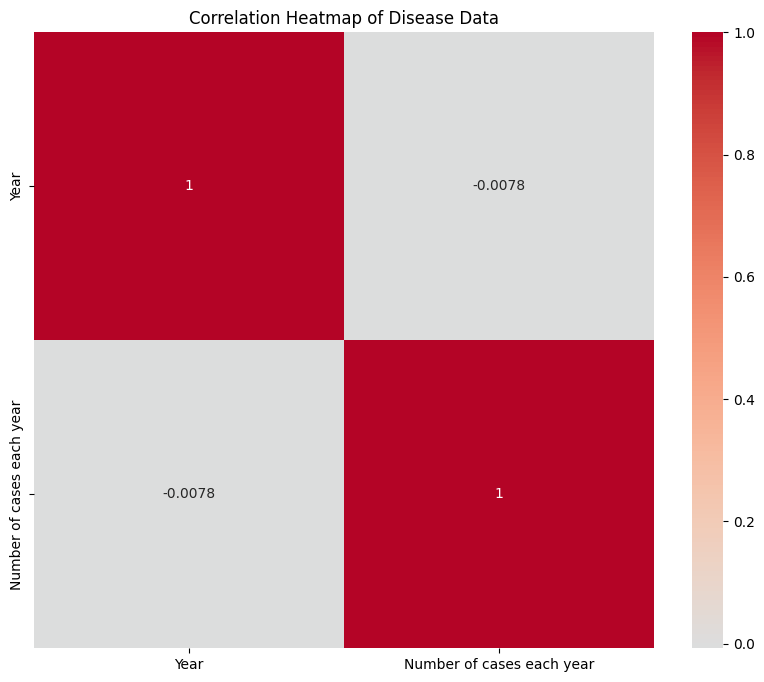

In [14]:
# Calculate correlation matrix
correlation_matrix = df_cleaned.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Disease Data')
plt.show()


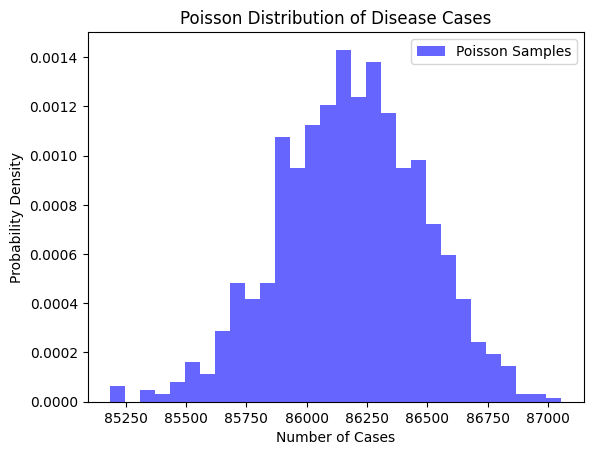

In [15]:
# Fit Poisson distribution to disease cases
mu = df_cleaned['Number of cases each year'].mean()
poisson_dist = poisson(mu)

# Generate random samples from Poisson distribution
samples = poisson_dist.rvs(size=1000)

# Plot histogram of samples
plt.hist(samples, bins=30, density=True, alpha=0.6, color='b', label='Poisson Samples')
plt.title('Poisson Distribution of Disease Cases')
plt.xlabel('Number of Cases')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


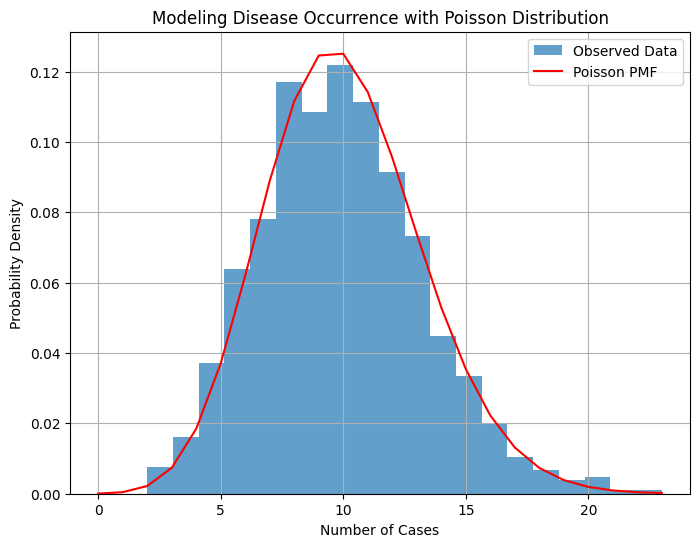

In [16]:
# Generate synthetic data representing disease occurrence (counts)
disease_counts = np.random.poisson(lam=10, size=1000)  # Using Poisson distribution with lambda=10

# Plot histogram of disease counts
plt.figure(figsize=(8, 6))
plt.hist(disease_counts, bins=20, density=True, alpha=0.7, label='Observed Data')

# Fit Poisson distribution to the data
mu = np.mean(disease_counts)
poisson_dist = stats.poisson(mu)
x = np.arange(0, np.max(disease_counts) + 1)
plt.plot(x, poisson_dist.pmf(x), 'r-', label='Poisson PMF')

plt.title('Modeling Disease Occurrence with Poisson Distribution')
plt.xlabel('Number of Cases')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
def conditional_probability(data, disease_A, disease_B):
    # Count occurrences of both diseases
    count_A_and_B = np.sum((data['Disease name'] == disease_A) & (data['Disease name'] == disease_B))
    count_B = np.sum(data['Disease name'] == disease_B)
    
    # Calculate conditional probability
    if count_B == 0:
        return 0  # If denominator is zero, return zero (or handle as appropriate)
    else:
        return count_A_and_B / count_B

def calculate_all_conditional_probabilities(data, disease_list):
    probabilities = {}
    
    for disease_A in disease_list:
        for disease_B in disease_list:
            if disease_A != disease_B:  # Avoid calculating self-referential probabilities
                key = f"P({disease_A} | {disease_B})"
                prob_A_given_B = conditional_probability(data, disease_A, disease_B)
                probabilities[key] = prob_A_given_B
    
    return probabilities

disease_list = [
    'Infectious Diseases', 'Neoplasms', 'Endocrine/Digestive/Immune Disorders',
    'Blood Circulation Diseases', 'Mental/Behavioral Disorders',
    'Nervous System/Sense Organs Diseases', 'Eye Diseases', 'Ear Diseases',
    'Respiratory Diseases', 'Digestive Diseases', 'Urogenital Diseases',
    'Reproductive System', 'Skin infections and underskin fat',
    'Musculoskeletal/Connective Tissue Disorders', 'Congenital Anomalies',
    'Ill-Defined Conditions', 'Perinatal Conditions', 'Injuries/Poisonings'
]

data = df_cleaned  
all_probabilities = calculate_all_conditional_probabilities(data, disease_list)

# Output all conditional probabilities
for key, value in all_probabilities.items():
    print(f"{key} = {value:.4f}")


P(Infectious Diseases | Neoplasms) = 0.0000
P(Infectious Diseases | Endocrine/Digestive/Immune Disorders) = 0.0000
P(Infectious Diseases | Blood Circulation Diseases) = 0.0000
P(Infectious Diseases | Mental/Behavioral Disorders) = 0.0000
P(Infectious Diseases | Nervous System/Sense Organs Diseases) = 0.0000
P(Infectious Diseases | Eye Diseases) = 0.0000
P(Infectious Diseases | Ear Diseases) = 0.0000
P(Infectious Diseases | Respiratory Diseases) = 0.0000
P(Infectious Diseases | Digestive Diseases) = 0.0000
P(Infectious Diseases | Urogenital Diseases) = 0.0000
P(Infectious Diseases | Reproductive System) = 0.0000
P(Infectious Diseases | Skin infections and underskin fat) = 0.0000
P(Infectious Diseases | Musculoskeletal/Connective Tissue Disorders) = 0.0000
P(Infectious Diseases | Congenital Anomalies) = 0.0000
P(Infectious Diseases | Ill-Defined Conditions) = 0.0000
P(Infectious Diseases | Perinatal Conditions) = 0.0000
P(Infectious Diseases | Injuries/Poisonings) = 0.0000
P(Neoplasms | 

Shapiro-Wilk Test Statistic: 0.9978, p-value: 0.2066


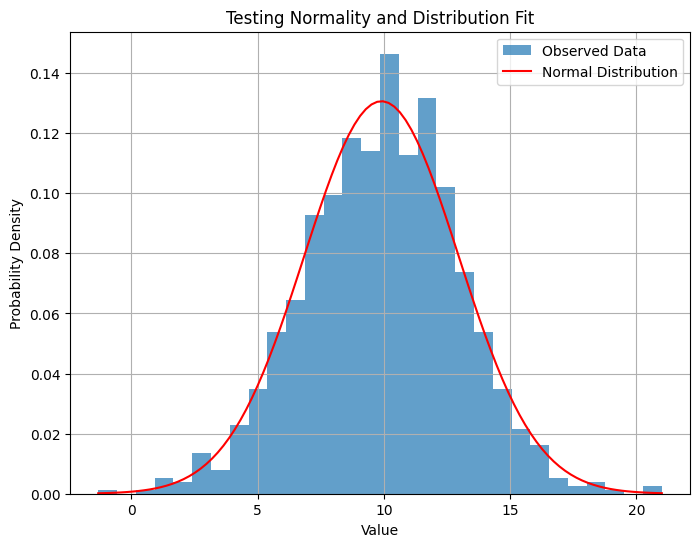

In [18]:
# Generate synthetic data (e.g., disease cases)
data = np.random.normal(loc=10, scale=3, size=1000)  # Normally distributed data

# Test for normality using Shapiro-Wilk test
stat, p_value = stats.shapiro(data)
print(f"Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")

# Visualize histogram and compare with normal distribution
plt.figure(figsize=(8, 6))
plt.hist(data, bins=30, density=True, alpha=0.7, label='Observed Data')

# Fit a normal distribution to the data
mu, sigma = np.mean(data), np.std(data)
normal_dist = stats.norm(mu, sigma)
x = np.linspace(np.min(data), np.max(data), 100)
plt.plot(x, normal_dist.pdf(x), 'r-', label='Normal Distribution')

plt.title('Testing Normality and Distribution Fit')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
from scipy.stats import ttest_ind

# Define the range of years (from 2011 to 2022)
years_range = range(2011, 2022) 

# Perform t-tests for consecutive years
for year in years_range:
    current_year_data = df_cleaned[df_cleaned['Year'] == year]['Number of cases each year']
    next_year_data = df_cleaned[df_cleaned['Year'] == (year + 1)]['Number of cases each year']
    
    # Perform t-test
    t_stat, p_value = ttest_ind(current_year_data, next_year_data, equal_var=False)  
    print(f"T-test Results for {year} vs. {year + 1}:")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"There is a significant difference in disease cases between {year} and {year + 1}.")
    else:
        print(f"There is no significant difference in disease cases between {year} and {year + 1}.")
    
    print()


T-test Results for 2011 vs. 2012:
T-statistic: -0.3408
P-value: 0.7352
There is no significant difference in disease cases between 2011 and 2012.

T-test Results for 2012 vs. 2013:
T-statistic: 0.1856
P-value: 0.8538
There is no significant difference in disease cases between 2012 and 2013.

T-test Results for 2013 vs. 2014:
T-statistic: 0.0152
P-value: 0.9880
There is no significant difference in disease cases between 2013 and 2014.

T-test Results for 2014 vs. 2015:
T-statistic: -0.1156
P-value: 0.9086
There is no significant difference in disease cases between 2014 and 2015.

T-test Results for 2015 vs. 2016:
T-statistic: 0.2942
P-value: 0.7706
There is no significant difference in disease cases between 2015 and 2016.

T-test Results for 2016 vs. 2017:
T-statistic: -0.2379
P-value: 0.8136
There is no significant difference in disease cases between 2016 and 2017.

T-test Results for 2017 vs. 2018:
T-statistic: 0.0012
P-value: 0.9990
There is no significant difference in disease cases

#  Explore

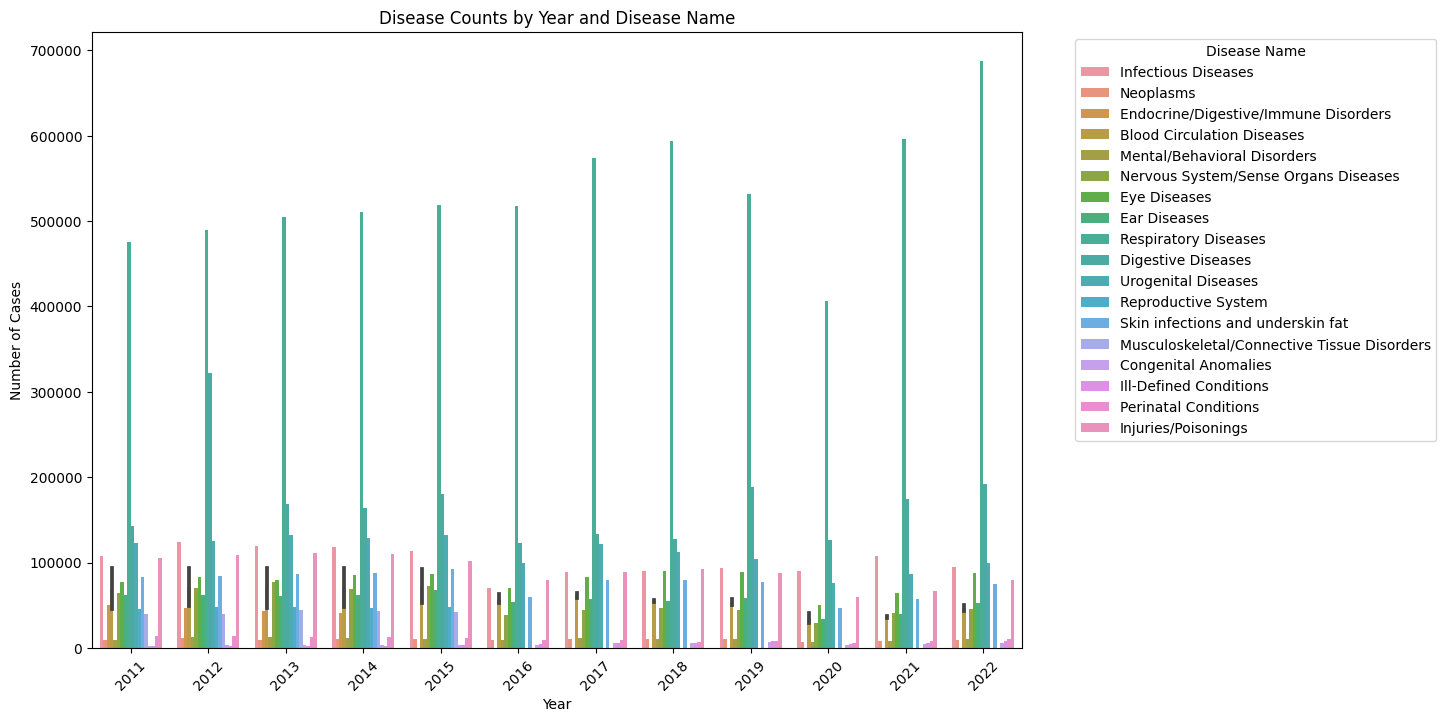

In [20]:
data = df_cleaned

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Year', y='Number of cases each year', hue='Disease name', data=data)
plt.title('Disease Counts by Year and Disease Name')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.legend(title='Disease Name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


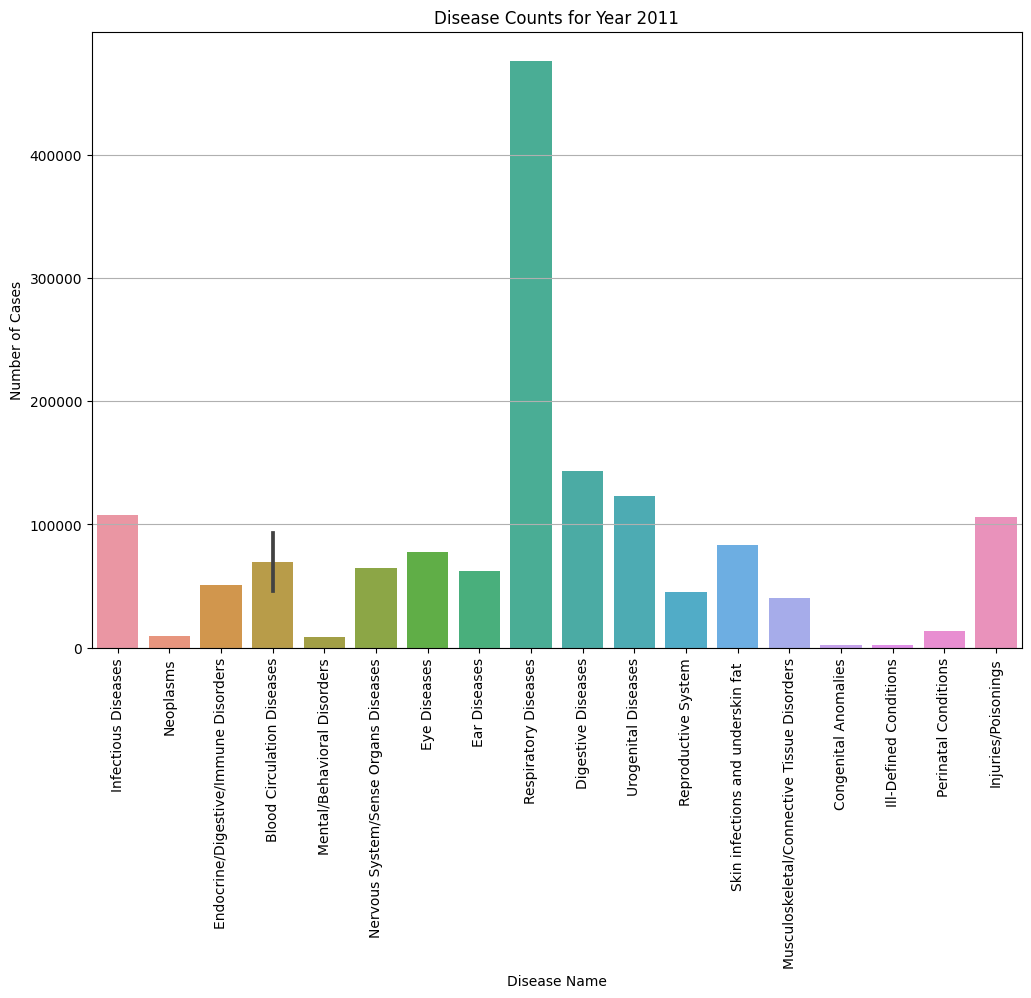

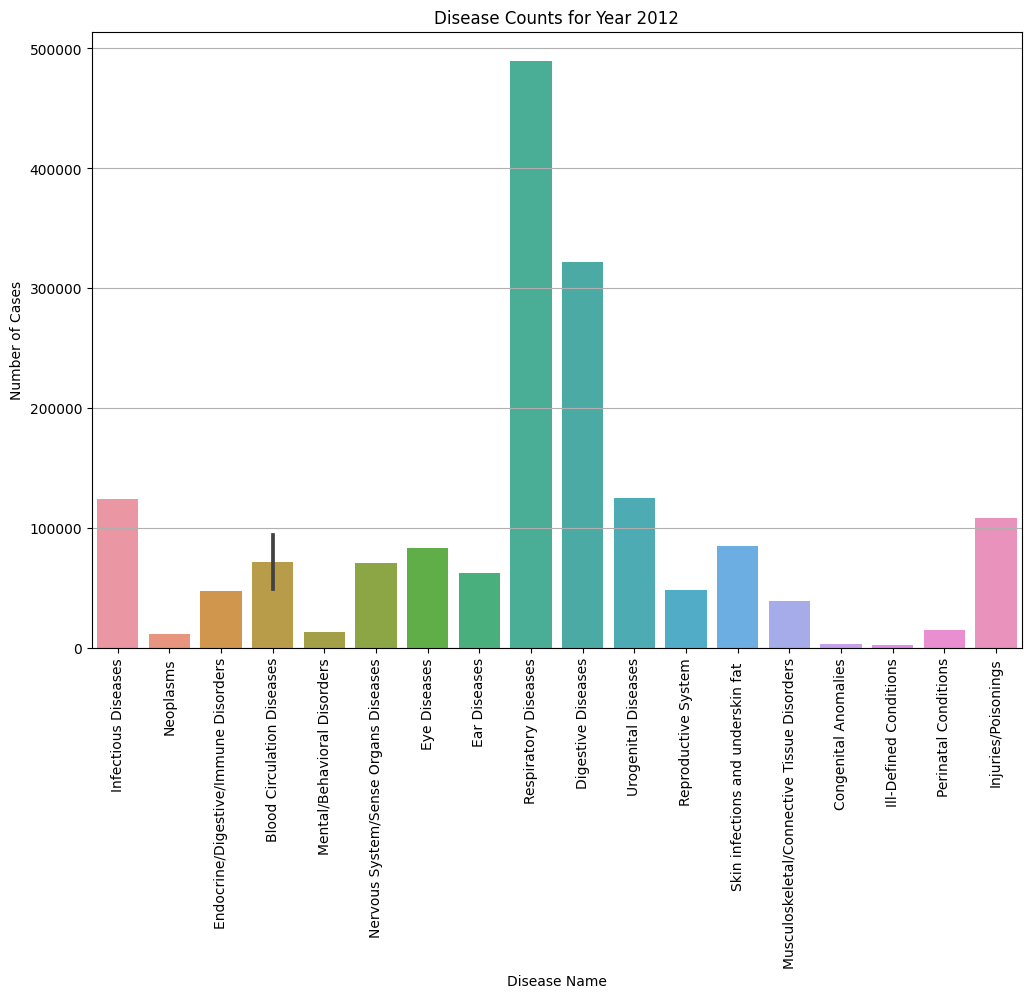

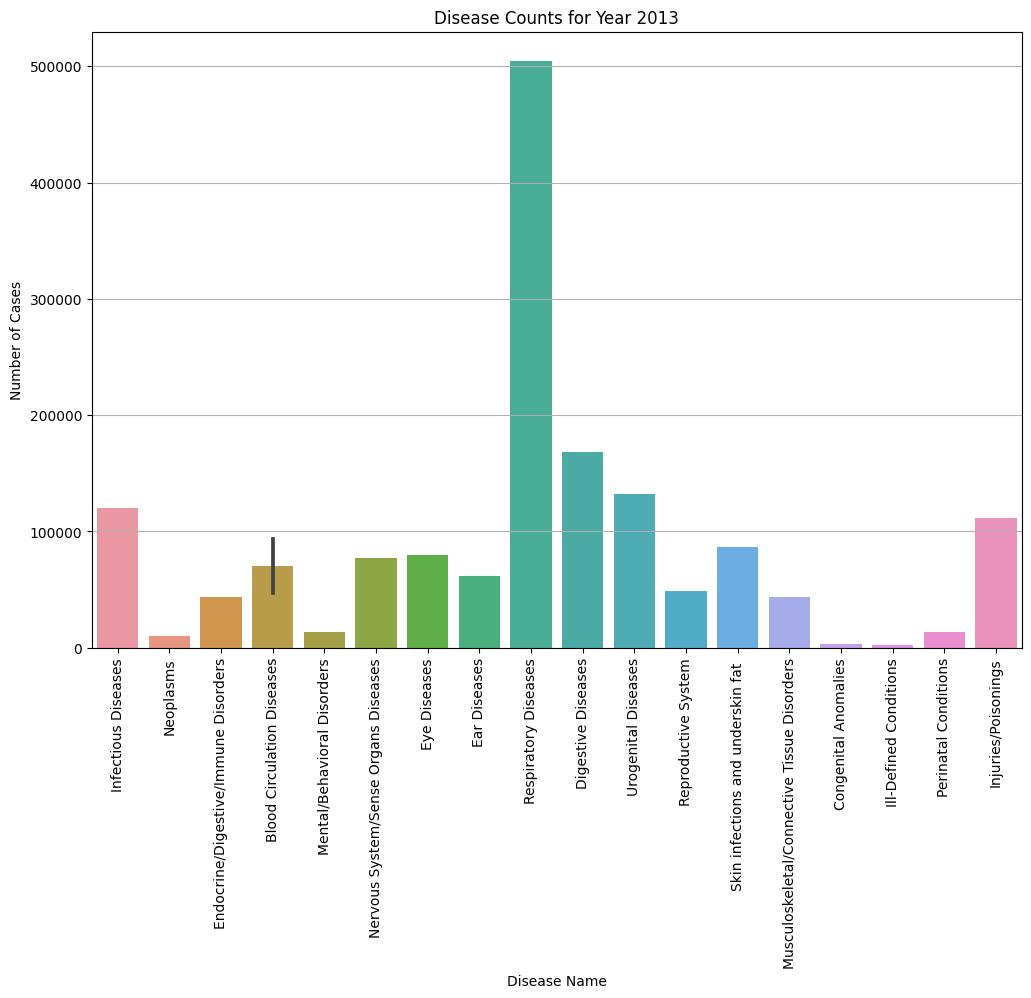

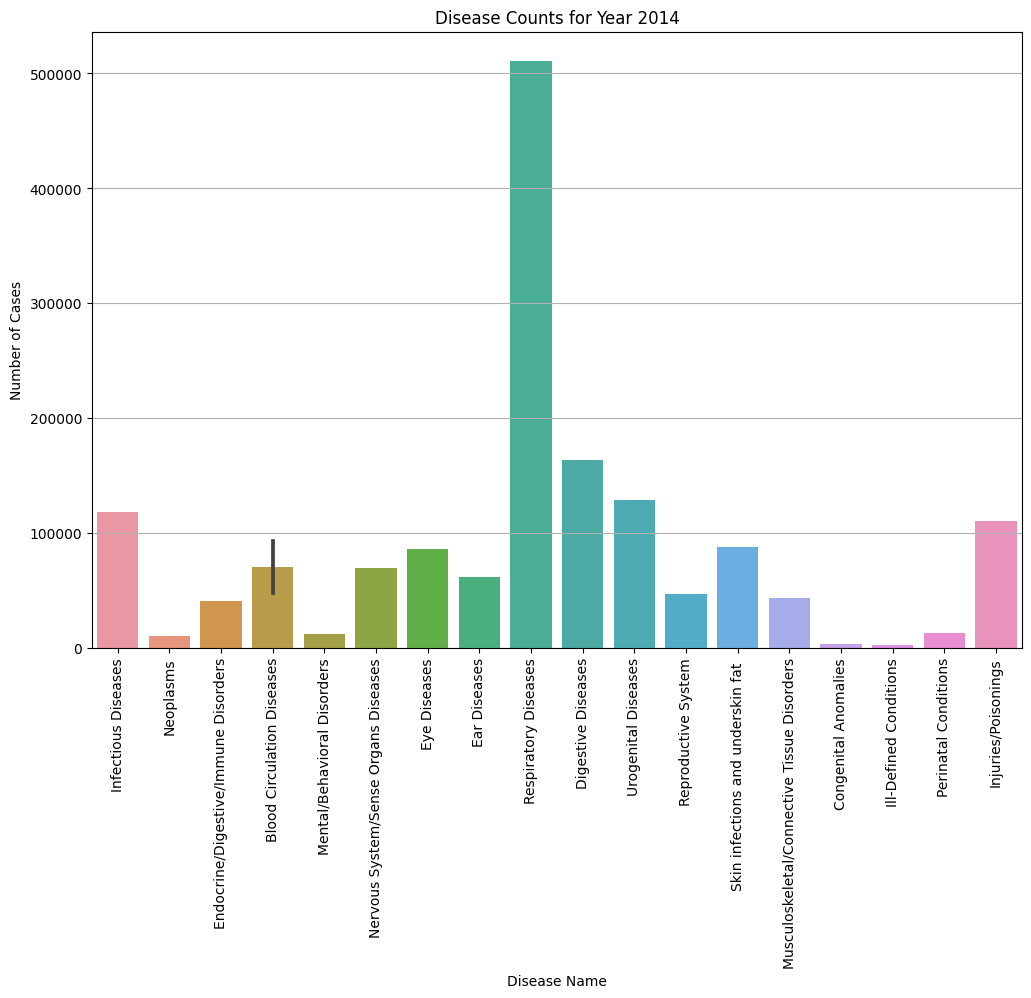

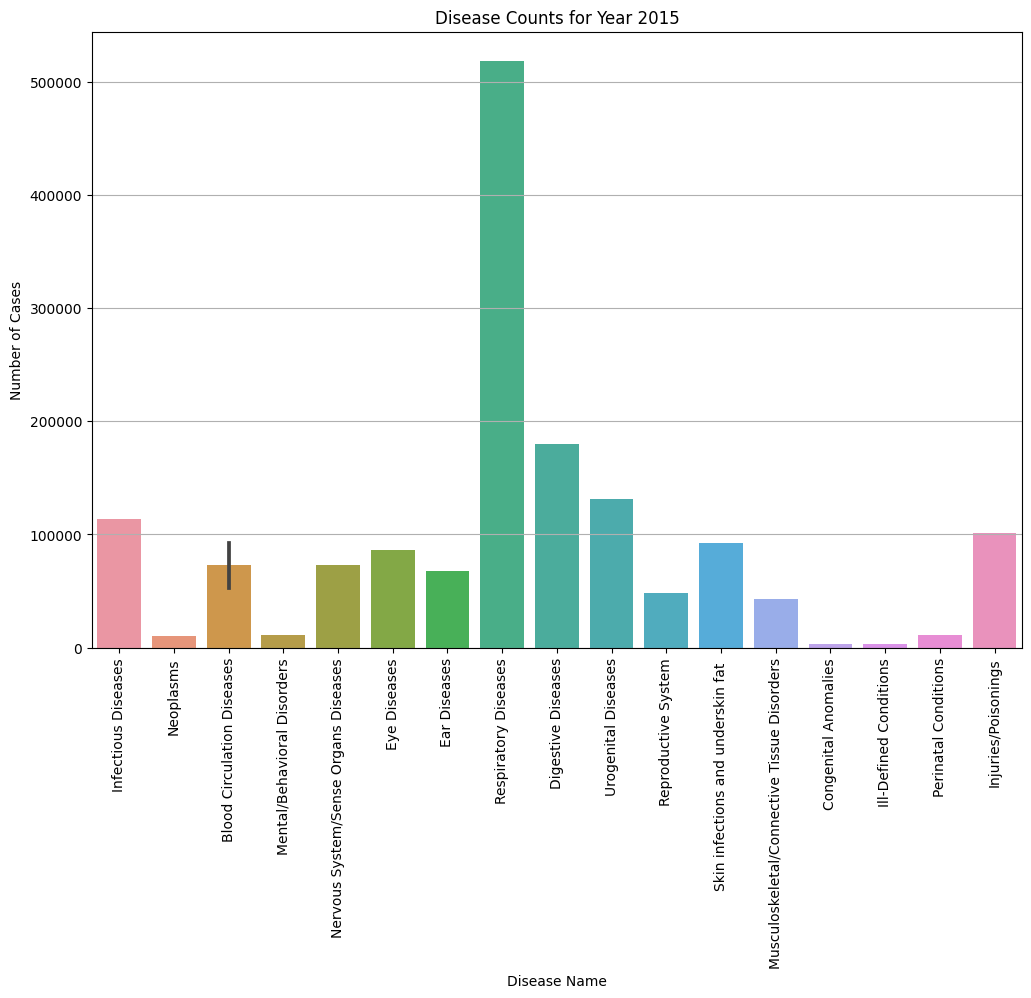

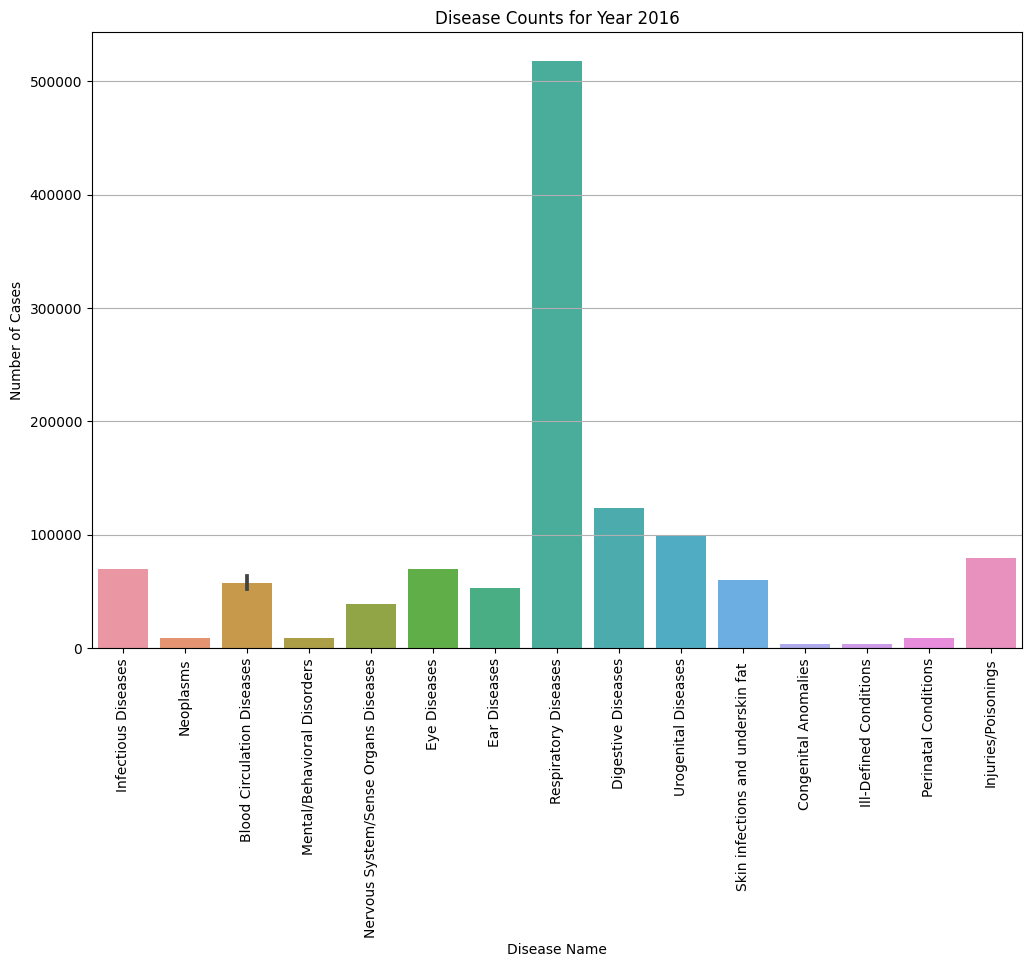

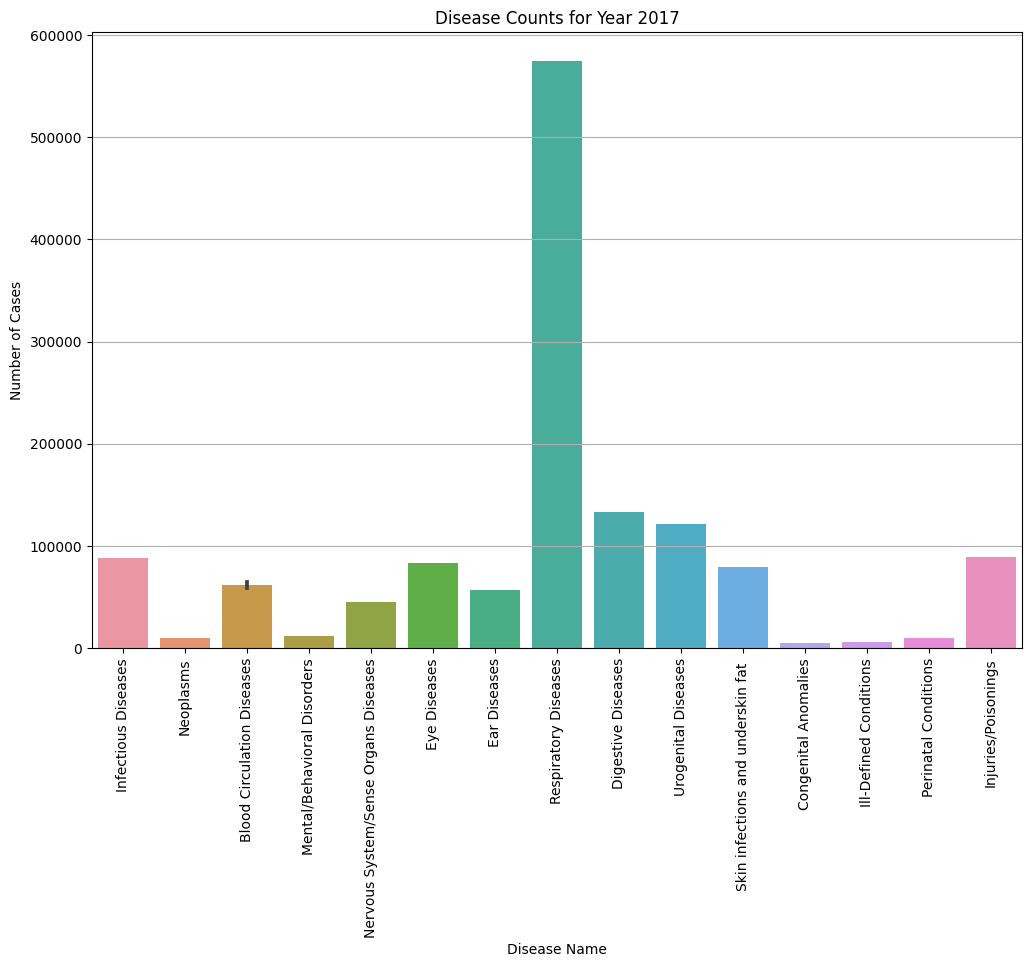

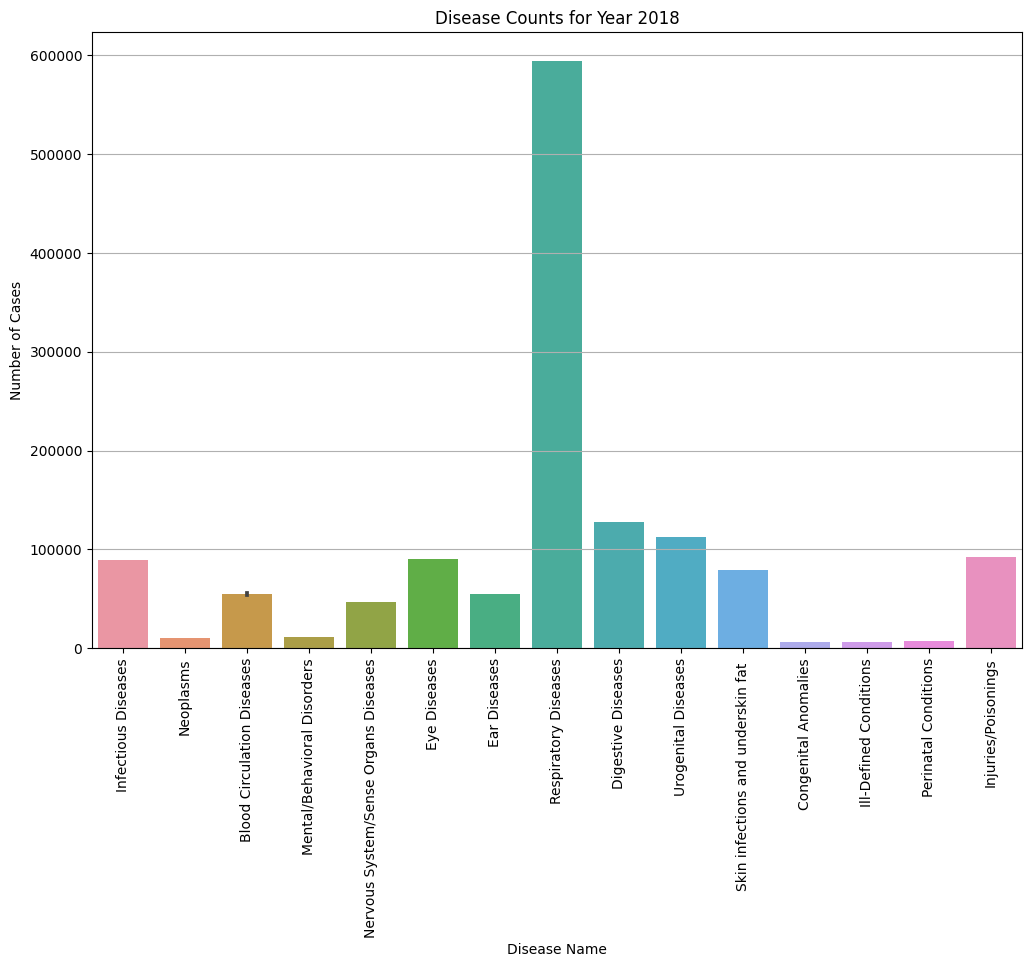

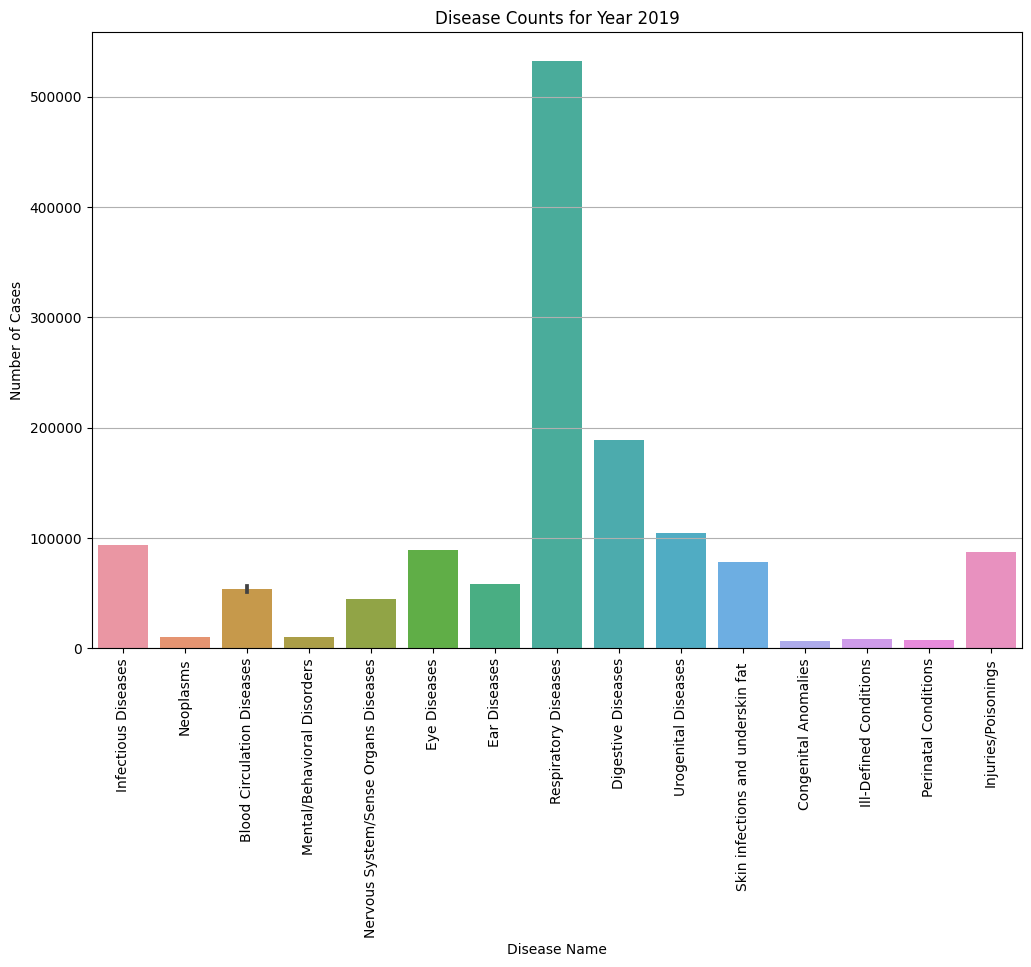

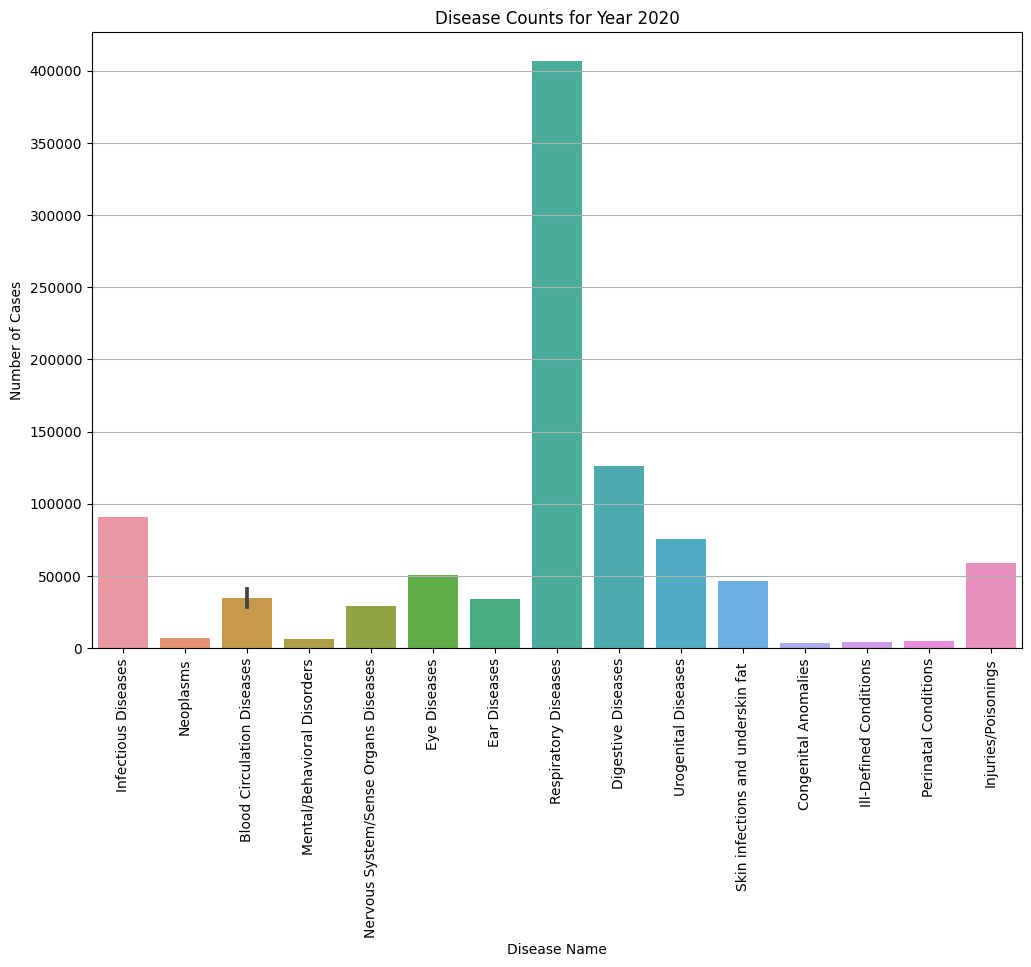

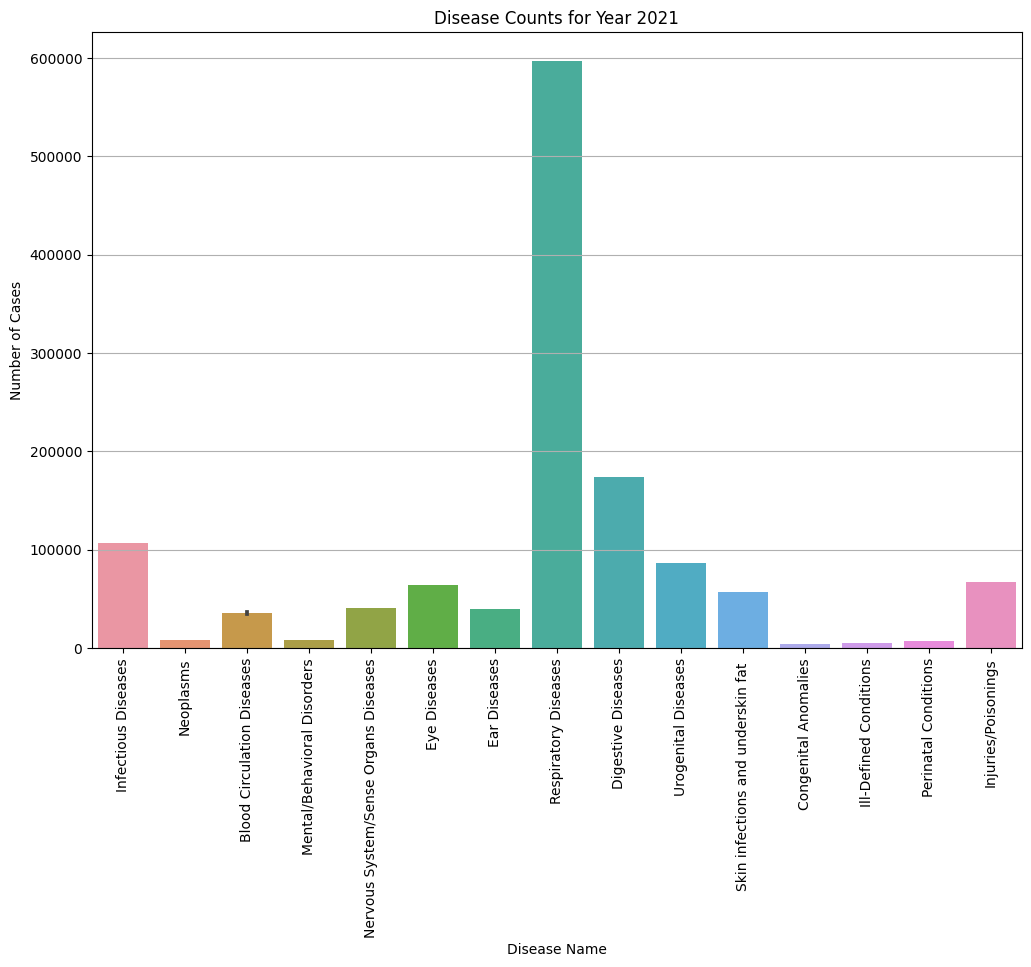

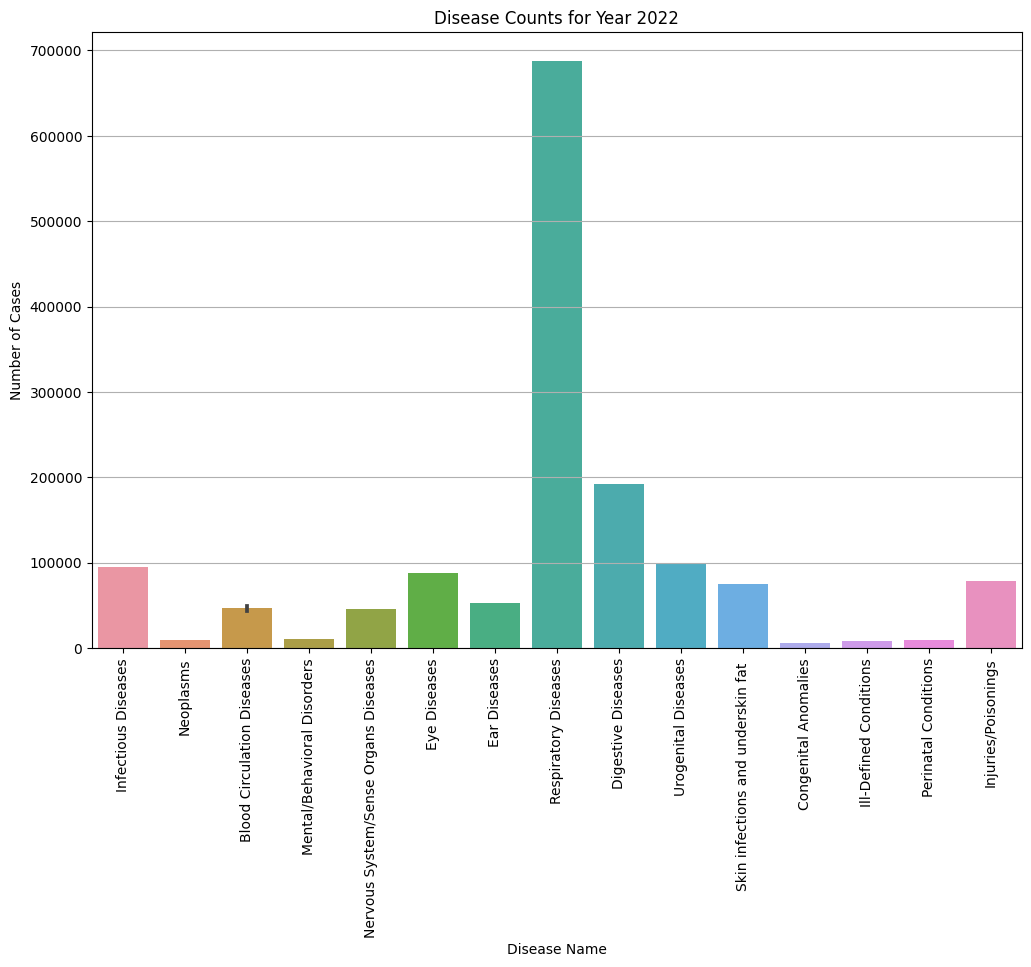

In [21]:
data = df_cleaned

# Get unique years in the dataset
unique_years = data['Year'].unique()

# Iterate over each year and create a separate bar chart
for year in unique_years:
    # Filter data for the current year
    year_data = data[data['Year'] == year]
    
    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Disease name', y='Number of cases each year', data=year_data)
    plt.title(f'Disease Counts for Year {year}')
    plt.xlabel('Disease Name')
    plt.ylabel('Number of Cases')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.grid(axis='y')
    plt.show()


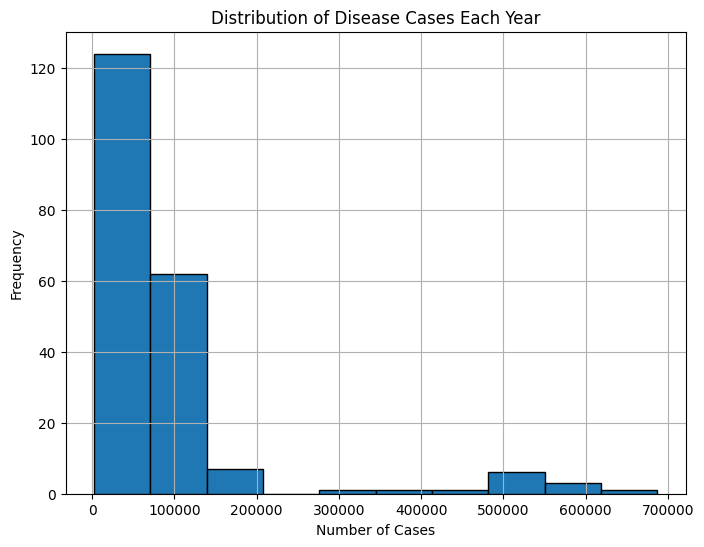

In [22]:
# Histogram of disease cases each year
plt.figure(figsize=(8, 6))
plt.hist(df_cleaned['Number of cases each year'], bins=10, edgecolor='black')
plt.title('Distribution of Disease Cases Each Year')
plt.xlabel('Number of Cases')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


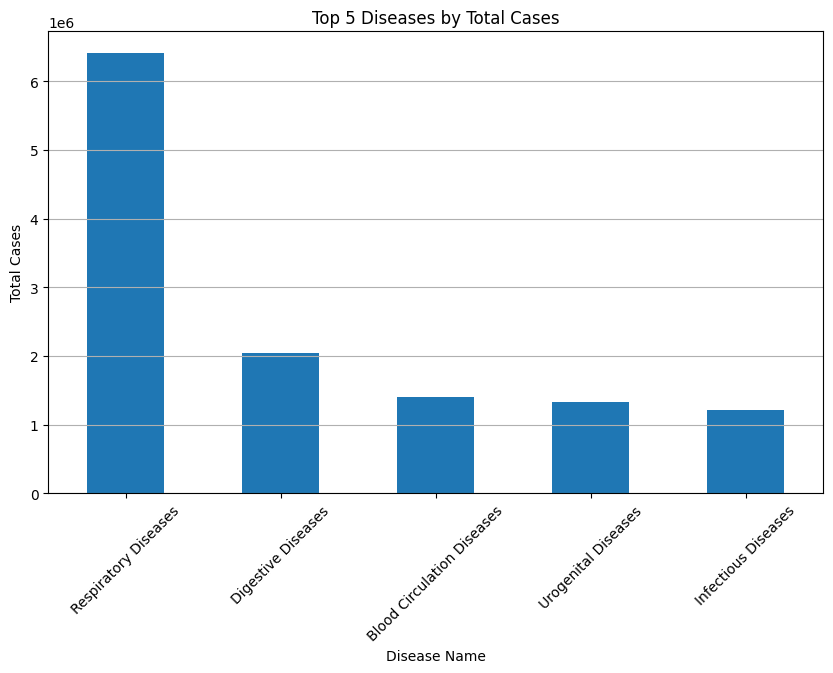

In [23]:
# Grouped bar chart for disease comparisons
top_diseases = df_cleaned.groupby('Disease name')['Number of cases each year'].sum().nlargest(5)
top_diseases.plot(kind='bar', figsize=(10, 6))
plt.title('Top 5 Diseases by Total Cases')
plt.xlabel('Disease Name')
plt.ylabel('Total Cases')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


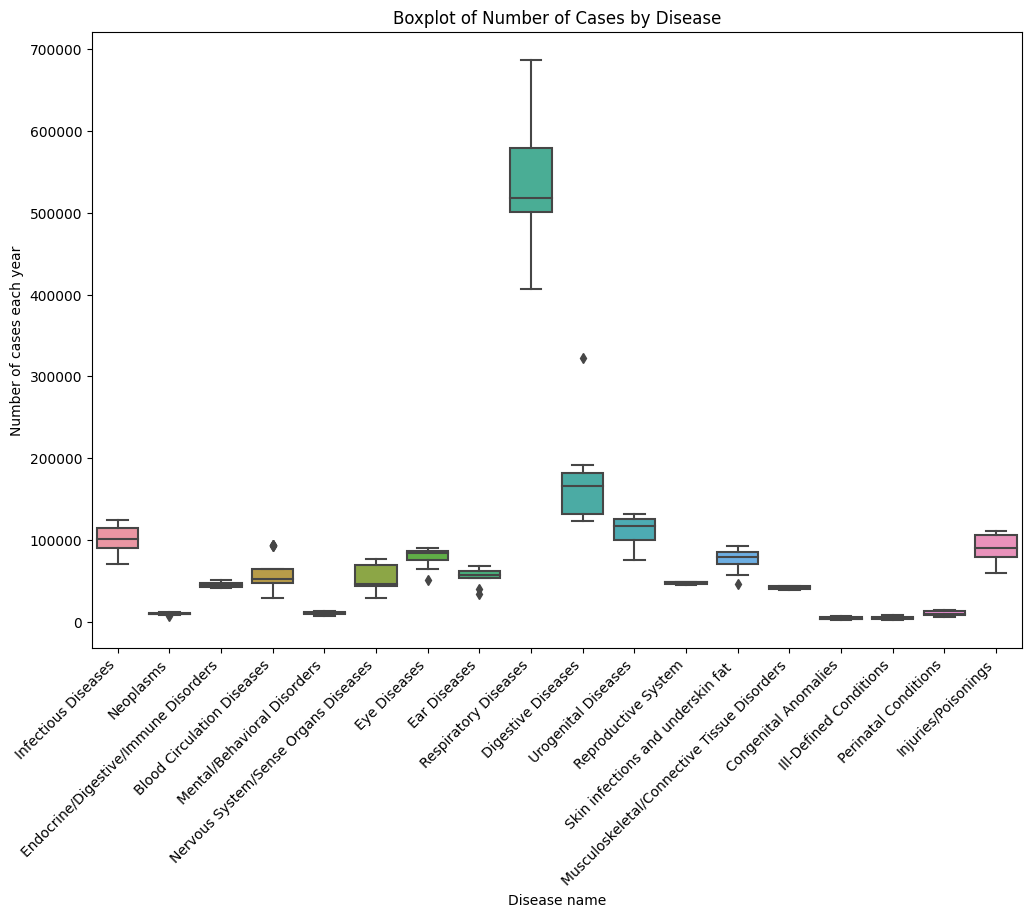

In [24]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Disease name', y='Number of cases each year', data=df_cleaned)
ax.set_title('Boxplot of Number of Cases by Disease')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()

/Users/mac/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

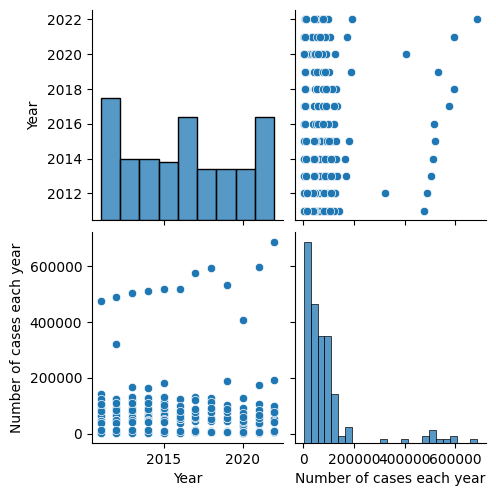

In [25]:
plt.figure(figsize=(12, 8))
sns.pairplot(df_cleaned[["Year","Number of cases each year"]])
plt.show();

# Build Model

In [26]:
# Features for clustering
features = ['Year', 'Number of cases each year']
X = df_cleaned[features]

## Iterate

In [27]:
# Set the range of clusters
n_clusters = range(2, 13)

# Initialize lists to store results
inertia_errors = []
silhouette_scores = []

# Supress warnings about KMeans memory leak on Windows
warnings.filterwarnings("ignore", category=UserWarning)

# Iterate through different numbers of clusters
for k in n_clusters:
    # Create a pipeline for preprocessing and K-Means
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42, n_init=10))
    
    # Fit the model to the data
    model.fit(X)
    
    # Append inertia and silhouette scores
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    silhouette_scores.append(silhouette_score(X, model.named_steps["kmeans"].labels_))

# Print the results
print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [237.8110944306594, 90.92957878964019, 65.23942668717234]

Silhouette Scores: [0.8811156998878297, 0.04658716922497262, 0.005540368789054157]


- **Silhouette Score**: Measures how well data points fit into their assigned clusters. It considers both the cohesion within clusters and the separation between clusters. A higher silhouette score (closer to +1) indicates well-defined and separated clusters, while a lower score suggests overlapping or poorly separated clusters.

- **Inertia (Within-Cluster Sum of Squares)**: Represents the sum of squared distances of data points to their cluster centroids. Lower inertia values indicate tighter and more compact clusters, reflecting better clustering performance.

In [28]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(x=n_clusters,y=inertia_errors,title="K-Means Model: Inertia vs Number of Clusters")
fig.update_layout(xaxis_title="Number of Clusters",yaxis_title="Inertia")
fig.show()

In [29]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(x=n_clusters,y=silhouette_scores,title="K-Means Model: Silhouette Score vs Number of Clusters")
fig.update_layout(xaxis_title="Number of Clusters",yaxis_title="Silhouette Score")
fig.show()

### Elbow Method Result

Based on the application of the elbow method, the optimal number of clusters (n_clusters) for the dataset is determined to be 3. This decision is made by identifying the "elbow" point in the plots.

In [30]:
final_model = make_pipeline(StandardScaler(),KMeans(n_clusters = 3,random_state=42))
final_model.fit(X)

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

# Communicate

In [31]:
labels = final_model.named_steps["kmeans"].labels_
xgb = X.groupby(labels).mean()
xgb

Year  Number of cases each year
0  2019.500000               53471.511111
1  2013.427184               60331.582524
2  2016.153846              517570.307692

In [32]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(xgb,barmode="group",title="Number of idsease over years by Cluster")
fig.update_layout(xaxis_title="Cluster",yaxis_title="Value")
fig.show()

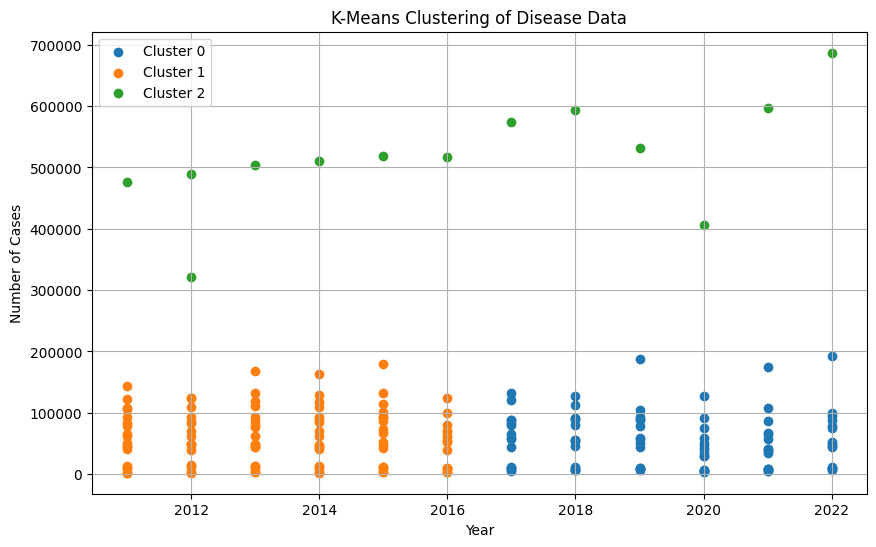

In [33]:
df_cleaned['Cluster'] = labels
# Visualize the clusters
plt.figure(figsize=(10, 6))
for cluster in range(3):
    cluster_data = df_cleaned[df_cleaned['Cluster'] == cluster]
    plt.scatter(cluster_data['Year'], cluster_data['Number of cases each year'], label=f'Cluster {cluster}')

plt.title('K-Means Clustering of Disease Data')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()

### Insights from Clustering Analysis:

1. **Cluster 1 (2011-2016, below 200,000 diseases):**
   - Represents a period with relatively low disease counts (each year < 200,000 cases).
   - Possible interpretation: Indicates a period of fewer health issues or effective disease control measures.

2. **Cluster 0 (2017-2022, below 200,000 diseases):**
   - Continuation of low disease counts observed in Cluster 1.
   - Possible interpretation: Reflects ongoing trends with sustained low disease prevalence.

3. **Cluster 2 (All years, above 200,000 diseases):**
   - Encompasses years with high disease counts (> 200,000 cases annually).
   - Possible interpretation: Highlights periods of heightened disease activity requiring focused interventions and resources.


In [34]:
inertia = final_model.named_steps["kmeans"].inertia_
print(f"Inertia: {inertia}")

Inertia: 90.92957878964019


In [35]:
silhouette_avg = silhouette_score(X, final_model.named_steps["kmeans"].labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.04658716922497262


# Build Dashboard

In [36]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go
import plotly.express as px
from dash.dependencies import Input, Output

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout
app.layout = html.Div([
    html.H1("Disease Segmentation Analysis in Kyrgyzstan"),
    
    # Add a dropdown to select the number of clusters
    dcc.Dropdown(
        id='cluster-dropdown',
        options=[
            {'label': '2 Clusters', 'value': 2},
            {'label': '3 Clusters', 'value': 3},
            {'label': '4 Clusters', 'value': 4},
            {'label': '5 Clusters', 'value': 5},
            {'label': '6 Clusters', 'value': 6},
        ],
        value=3  # Default value
    ),
    
    # Add a graph to display the disease clustering scatter plot
    dcc.Graph(id='disease-clustering-scatter-plot'),

    # Add a graph to display the bar chart of disease counts by cluster
    dcc.Graph(id='disease-counts-by-cluster')
])

# Define callback function to update the scatter plot and bar chart based on selected cluster number
@app.callback(
    [Output('disease-clustering-scatter-plot', 'figure'),
     Output('disease-counts-by-cluster', 'figure')],
    [Input('cluster-dropdown', 'value')]
)
def update_visuals(selected_cluster):
    # Select features for disease clustering
    features = ['Year', 'Number of cases each year']
    X = df_cleaned[features]

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform K-Means clustering with the selected number of clusters
    kmeans = KMeans(n_clusters=selected_cluster, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Add cluster labels to the dataset
    df_cleaned['Cluster'] = labels

    # Create scatter plot to visualize disease clustering
    scatter_data = []
    for cluster in range(selected_cluster):
        cluster_data = df_cleaned[df_cleaned['Cluster'] == cluster]
        scatter_data.append(
            go.Scatter(
                x=cluster_data['Year'],
                y=cluster_data['Number of cases each year'],
                mode='markers',
                name=f'Cluster {cluster}'
            )
        )

    layout_scatter = go.Layout(
        title='K-Means Clustering of Disease Data',
        xaxis=dict(title='Year'),
        yaxis=dict(title='Number of Cases'),
        hovermode='closest'
    )

    scatter_plot_fig = go.Figure(data=scatter_data, layout=layout_scatter)

    # Create bar chart to display disease counts by cluster
    xgb = df_cleaned.groupby(['Cluster', 'Year']).size().reset_index(name='Count')
    fig_bar_chart = px.bar(xgb, x='Cluster', y='Count', color='Year', barmode='group',
                           title='Number of Diseases over Years by Cluster')
    fig_bar_chart.update_layout(xaxis_title="Cluster", yaxis_title="Count")

    return scatter_plot_fig, fig_bar_chart

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Summary:

The project involved analyzing a dataset containing the number of reported disease cases in Kyrgyzstan over multiple years. The dataset was carefully cleaned to remove any missing or irrelevant information, ensuring the data was ready for analysis.

Statistical techniques were applied to uncover trends in disease occurrence over time. Descriptive statistics provided insights into the average, median, and variation of disease cases each year. Visualizations such as histograms and boxplots were used to showcase the distribution and variability of disease data.

Advanced modeling techniques like clustering (using K-Means) were employed to group diseases based on their reported patterns over the years. This allowed for the identification of distinct disease clusters and trends within the dataset.

To make the findings more accessible, an interactive dashboard was developed using Dash. This dashboard enabled users to explore disease clusters and trends visually, providing a user-friendly interface to interact with the analyzed data.

Overall, the project aimed to provide a comprehensive understanding of disease patterns in Kyrgyzstan, leveraging data analysis, statistical methods, and visualization to gain insights into public health trends over time.